Simplified version of prepare_stratification.ipynb. Currently, only uses one T &S profile (#21).

In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm

from seawater import geostrophic
from seawater import eos80

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

# Observations

In [2]:
# Load two datasets
ts_data_shal = sio.loadmat('../data/for_stratification/canyonTSdata.mat')
ts_data_deep = sio.loadmat('../data/for_stratification/canyonTSdata2.mat')

In [3]:
# Extract important variables
longitudes = np.concatenate((ts_data_shal['loncanyon'][0], ts_data_deep['loncanyon2'][0]),axis=0)
latitudes = np.concatenate((ts_data_shal['latcanyon'][0], ts_data_deep['latcanyon2'][0]),axis=0)
years = np.concatenate((ts_data_shal['yrcanyon'][0], ts_data_deep['yrcanyon2'][0]),axis=0)
days = np.concatenate((ts_data_shal['daycanyon'][0], ts_data_deep['daycanyon2'][0]),axis=0)
con_temps = np.concatenate((ts_data_shal['tempcanyon'], ts_data_deep['tempcanyon2']),axis=1)
abs_salts = np.concatenate((ts_data_shal['salcanyon'], ts_data_deep['salcanyon2']),axis=1)
depths = np.concatenate((ts_data_shal['depthcanyon'], ts_data_deep['depthcanyon2']),axis=1) * -1

# Dates these measurements were taken
dates = []
for i in range(len(days)):
    date = (datetime.datetime(years[i], 1, 1) + datetime.timedelta(days[i] - 1)).strftime('%b %y')
    dates.append(date)

# Temperature and Salinity Interpolation Functions

In [4]:
def interpolate_votemper(interp_ctemp, data_temp, vertical_spacing, bathy_shape):
    ''' This function interpolates the conservative temperature to the depths
    specified in the vertical spacing. 
    
    :arg interp_ctemp: interpolation function
    :arg data_temp: conservative temperature data
    :arg vertical_spacing: depth steps 
    :arg bathy_shape: domain bathymetry
    '''
    votemper = np.zeros((1, len(vertical_spacing), bathy_shape[0], bathy_shape[1]))
    votemper[0,0,:,:] = data_temp[0]

    for id in range(1, len(vertical_spacing)):
        print(vertical_spacing[id])
        for x in range(0, bathy_shape[1]):
            for y in range(0, bathy_shape[0]):
                votemper[0, id, y, x] = interp_ctemp(vertical_spacing[id])
    return votemper

def interpolate_vosaline(interp_asalt, data_salt, vertical_spacing, bathy_shape):
    ''' This function interpolates the absolute salinity to the depths
    specified in the vertical spacing. 
    
    :arg interp_asalt: interpolation function
    :arg data_salt: absolute salinity data
    :arg vertical_spacing: depth steps 
    :arg bathy_shape: domain bathymetry
    '''
    vosaline = np.zeros((1, len(vertical_spacing), bathy_shape[0], bathy_shape[1]))
    vosaline[0,0,:,:] = data_salt[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, bathy_shape[1]):
            for y in range(0, bathy_shape[0]):
                vosaline[0, id, y, x] = interp_asalt(vertical_spacing[id])
    return vosaline

In [5]:
def fill_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

In [6]:
def prepare_profile(profile_number, depths, con_temps, abs_salts):
   
    full_depth = depths[:, profile_number]
    ind_end = np.where(full_depth == np.nanmax(full_depth))[0][0]
    prof_depth = full_depth[:ind_end+1]

    full_ctemp = con_temps[:, profile_number]
    prof_ctemp = full_ctemp[:ind_end+1]

    full_asalt = abs_salts[:, profile_number]
    prof_asalt = full_asalt[:ind_end+1]
    
    prof_depth = fill_nans(prof_depth)
    prof_ctemp = fill_nans(prof_ctemp)
    prof_asalt = fill_nans(prof_asalt)
    
    return prof_depth, prof_ctemp, prof_asalt

In [7]:
def prepare_interpolation(prof_depth, prof_ctemp, prof_asalt):

    interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, kind='cubic', 
                                    bounds_error=False, fill_value=prof_ctemp[-1], assume_sorted=False)
    interp_asalt = interpolate.interp1d(prof_depth, prof_asalt, kind='cubic', 
                                    bounds_error=False, fill_value=prof_asalt[-1], assume_sorted=False)
    
    return interp_ctemp, interp_asalt

In [8]:
def generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, vertical_spacing, bathy_shape):
    
    strat_votemper = interpolate_votemper(interp_ctemp, prof_ctemp, vertical_spacing, bathy_shape)
    strat_vosaline = interpolate_vosaline(interp_asalt, prof_asalt, vertical_spacing, bathy_shape)
    
    return strat_votemper, strat_vosaline

In [9]:
def full_stratification(profile_number, depths, con_temps, abs_salts, vertical_spacing, bathy_shape):
    
    prof_depth, prof_ctemp, prof_asalt = prepare_profile(profile_number, depths, con_temps, abs_salts)
    interp_ctemp, interp_asalt = prepare_interpolation(prof_depth, prof_ctemp, prof_asalt)
    strat_votemper, strat_vosaline = generate_interpolation(interp_ctemp, interp_asalt, prof_ctemp, prof_asalt, 
                                                            vertical_spacing, bathy_shape)
    
    return strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt

In [10]:
def plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, bathy_shape):

    xs, ys = 58, 58; c = 'dodgerblue'
    fig, (ax2, ax3, ax4) = plt.subplots(1,3,figsize=(14,6)); fig.tight_layout()

    ax2.plot(vertical_spacing, c = 'forestgreen', lw = 2, marker = 'o', linestyle = '-')
    ax2.set_title('depths ' + str(vertical_spacing.shape))
    ax2.set_ylim(prof_depth[-1], 0)

    ax3.plot(prof_ctemp, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax3.plot(strat_votemper[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax3.set_title('temperature ' + str(prof_ctemp.shape) + ' ' + str(strat_votemper.shape))
    ax3.legend(loc=4); ax3.set_ylim(prof_depth[-1], 0)

    ax4.plot(prof_asalt, prof_depth, c = 'gray', lw=2, marker ='o', linestyle='-', label='data', alpha=0.4)
    ax4.plot(strat_vosaline[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax4.set_title('salinity ' + str(prof_asalt.shape) + ' ' + str(strat_vosaline.shape))
    ax4.legend(loc=3); ax4.set_ylim(prof_depth[-1], 0)

    plt.show()

    return fig

# Creating Individual Profile

In [11]:
path_bath = 'ideal_bathy_for_agrif.nc'
path_mesh = 'unique_directory/mesh_mask.nc'

file_bath = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/' + path_bath)
file_mesh = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_for_agrif_255x190/create_mesh_mask_run/' + path_mesh)

bathy_shape = file_bath['Bathymetry'][:].shape
vertical_spacing = file_mesh['gdept_1d'][0]

In [12]:
profile_number = 21
strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt = full_stratification(profile_number, 
                                                                                         depths, con_temps, abs_salts, 
                                                                                        vertical_spacing, bathy_shape)

13.125
21.875
30.625
39.375
48.125
56.875
65.625
74.375
83.125
91.875
100.625
109.375
118.125
126.875
135.625
144.375
153.125
161.875
170.625
179.375
188.125
196.875
205.625
214.375
223.125
231.875
240.625
249.375
258.125
266.875
275.625
284.375
293.125
301.875
310.625
319.375
328.125
336.875
345.625
354.375
363.125
371.875
380.625
389.375
398.125
406.875
415.625
424.375
433.125000002
441.875000013
450.625000095
459.3750007
468.125005173
476.875038221
485.625282419
494.377086697
503.140412645
511.988554678
521.446598619
534.672168119
560.331890341
598.425765285
640.287165789
682.7584682
725.314586697
767.882226863
810.45142711
853.020838506
895.590278478
938.159722317
980.729166679
1023.29861111
1065.86805556
1108.4375
1151.00694444
1193.57638889
1236.14583333
1278.71527778
1321.28472222


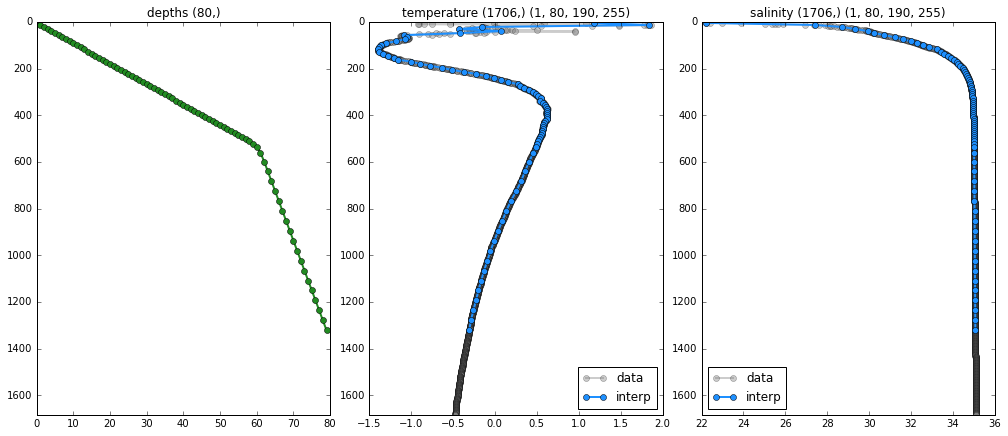

In [13]:
fig = plot_interpolations(strat_votemper, strat_vosaline, prof_depth, prof_ctemp, prof_asalt,
                        vertical_spacing, bathy_shape)

In [14]:
t_file = nc.Dataset('../NEMO_files/temperature/temperature_for_agrif', 'w', zlib=True)
t_file.createDimension('x',bathy_shape[1])
t_file.createDimension('y',bathy_shape[0])
t_file.createDimension('deptht',size = vertical_spacing.shape[0])
t_file.createDimension('time_counter', None)
deptht = t_file.createVariable('deptht', 'float32', ('deptht'))
votemper = t_file.createVariable('votemper', 'float32', ('time_counter','deptht','y','x'))
deptht = vertical_spacing[:]
votemper[0] = strat_votemper[:]
t_file.close()

s_file = nc.Dataset('../NEMO_files/salinity/salinity_for_agrif', 'w', zlib=True)
s_file.createDimension('x',bathy_shape[1])
s_file.createDimension('y',bathy_shape[0])
s_file.createDimension('deptht',size = vertical_spacing.shape[0])
s_file.createDimension('time_counter', None)
deptht = s_file.createVariable('deptht', 'float32', ('deptht'))
vosaline = s_file.createVariable('vosaline', 'float32', ('time_counter','deptht','y','x'))
deptht = vertical_spacing[:]
vosaline[0] = strat_vosaline[:]
s_file.close()